In [28]:
lv_2d_file = '/home/katya/Projects/Metabol/LargeVis/dataset_tfidf_sim_2D.lv'
metadata_file = '/home/katya/Dropbox/metabolite annotation/170426 all .8 0 .8/Dnodes.csv'
metadata_column_range = (7,20)
ds_names = '/home/katya/Projects/Metabol/doc_ids.txt'

# load ds names
import pickle
with open(ds_names, 'rb') as f: doc_ids = pickle.load(f)

# load metadata
metadata = []
for i, line in enumerate(open(metadata_file)):
    vec = line.strip().split(',')
    if i == 0:
        mnames = vec[metadata_column_range[0]:metadata_column_range[1]+1]
    else:
        metadata.append(vec[metadata_column_range[0]:metadata_column_range[1]+1])

cord_met_data = []
for i, line in enumerate(open(lv_2d_file)):
    vec = line.strip().split(' ')
    if i == 0:
        N = int(vec[0])
        M = int(vec[1])
    elif i <= N:
        cord_met_data.append([float(vec[-2]), float(vec[-1])] + metadata[i])
metadata = []

import pandas as pd
columns = ['x','y'] + mnames
plot_data = pd.DataFrame(cord_met_data,columns=columns)
cord_met_data = []

#Sample_Information.Organism
#print(plot_data['Sample_Information.Organism_Part'].astype('category'))

In [29]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import random

plotly.tools.set_credentials_file(username='eovchinn', api_key='hM44KtkqNK1zUI96Pp7z')

# create colormap
cat = 'Sample_Information.Organism_Part'
unique_values = plot_data[cat].unique().tolist()

colors = []
for i in range(0,len(unique_values )):
    colors.append('%06X' % random.randint(0, 0xFFFFFF))

trace = go.Scatter(
    x = plot_data['x'].tolist(),
    y = plot_data['y'].tolist(),
    mode = 'markers',
    marker = dict(color = []),
    text = doc_ids
)

for row in plot_data.iterrows():
    #print(row[1][cat])
    c = colors[unique_values.index(row[1][cat])]
    trace.marker.color.append(c)
    #trace.text.append(row[1][cat])

data = [trace]

py.iplot(data, filename='basic-scatter')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~eovchinn/0 or inside your plot.ly account where it is named 'basic-scatter'


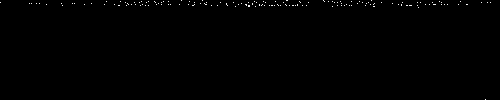

In [46]:
# this is critical. Datashader depends on defining an image of a specified size in pixels
plot_width  = int(500)
plot_height = int(100)
background = "black"

import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display
import numpy as np
from seaborn import color_palette,palplot

# this function actually generates the datashader image 
export = partial(export_image, background = background, export_path="export")

cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height)
agg = cvs.points(plot_data, 'x', 'y')

export(tf.shade(agg, cmap = cm(Greys9), how='eq_hist'),'tempfile')

In [40]:
# `cat` specifies which categorical column we want to color by
def create_image(w=plot_width, h=plot_height,cat=None,color_key=None):
    df = plot_data
    # now that we've done our sampling we can convert the column to a category type
    df[cat] = df[cat].astype('category')
    # unless we explicitly pass a {category:color} dictionary, generate the color map
    if color_key is None:
        unique_values = df[cat].unique()
        # this is s kludge to handle the fact that some plotting libraries don't handle seaborn color paletes well (just converting to hex color names)
        colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette('Set1',n_colors=len(unique_values)))).astype(int)]
        # use matplotlib to draw a legend
        #keyplot(colors,unique_values)
        color_key = {val:color for val,color in zip(unique_values,colors)}   
                
    # now the plotting command is the sameas above, except we use a `color_key` arugment to tell datashader how to color each point
    cvs = ds.Canvas(plot_width=w, plot_height=h)
    agg = cvs.points(df, 'x', 'y')
    img = tf.shade(agg, color_key=color_key, how='eq_hist')
    return img

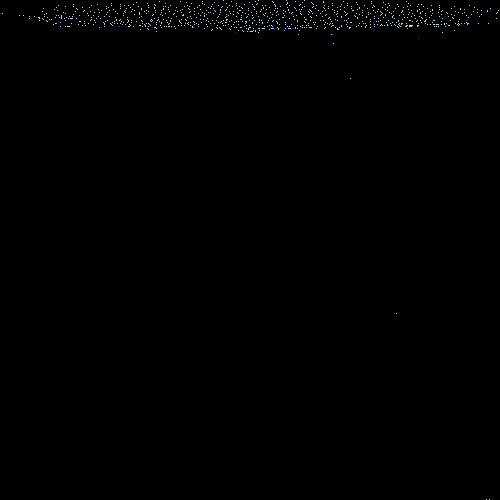

In [41]:
export(create_image(cat='Sample_Information.Organism_Part'),'tempfile')